In [122]:
# Step 1: Import the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

#Load the Files
user_reviews_df = pd.read_csv('googleplaystore_user_reviews.csv')
app_data_df = pd.read_csv('googleplaystore.csv')
child_app_data_df = pd.read_csv('Apps.csv')
child_review_data_df = pd.read_csv('Reviews.csv')



In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


In [192]:

# Main Data
dfMainApps = pd.read_csv("googleplaystore.csv")
dfMainReviews = pd.read_csv("googleplaystore_user_reviews.csv")

# Child Data
dfChildApps = pd.read_csv("Apps.csv")
dfChildReviews = pd.read_csv("Reviews.csv")

# renaming different attributes
dfMainApps.rename(columns={"App": "App Name"}, inplace=True)
dfMainReviews.rename(columns={"App": "App Name"}, inplace=True)

dfChildApps.rename(columns={"title": "App Name", "appId": "app_Id"}, inplace=True)
dfChildReviews.rename(columns={"repliedAt": "Review Date"}, inplace=True)

# first merging the datasets
mergedMain = pd.merge(dfMainApps, dfMainReviews, on='App Name', how='inner')
mergedChild = pd.merge(dfChildApps, dfChildReviews, on='app_Id', how='inner')


# just getting the apps in 'Apps.csv' data and dates of them. By merging this datasets we reduced the number of rows.
mergedAll = pd.merge(mergedMain, mergedChild[['App Name', 'Review Date']], on='App Name', how='left')

mergedAll.drop_duplicates(inplace=True)

# Handle NaN values again in the merged DataFrame
mergedAll.dropna(inplace=True)


# Check for any remaining NaNs
print("Total Missing Values after NaN removal and outlier removal:")
print(mergedAll.isnull().sum())

# Convert Size to numeric values (in MB), handling non-numeric values
mergedAll['Size'] = mergedAll['Size'].replace('Varies with device', np.nan)
mergedAll['Size'] = mergedAll['Size'].str.replace('M', '').str.replace('k', 'e-3')
mergedAll['Size'] = pd.to_numeric(mergedAll['Size'], errors='coerce')

# Drop any remaining rows with missing or non-numeric values in 'Size'
mergedAll.dropna(subset=['Size'], inplace=True)


# Installs to numeric values
mergedAll['Installs'] = mergedAll['Installs'].astype(str).str.replace('+', '').str.replace(',', '').astype(int)

# Encode the Price column
mergedAll['Price'] = mergedAll['Price'].astype(str).str.replace('$', '', regex=False).astype(float)

mergedAll['Size'] = mergedAll['Size'].astype(str).str.replace('M', '', regex=False).astype(float)

mergedAll['Rating'] = mergedAll['Rating'].astype(float)

import datetime

# Convert 'Review Date' column to datetime format
mergedAll['Review Date'] = pd.to_datetime(mergedAll['Review Date'])

# Change the format of 'Review Date' to dd-mm-yyyy
mergedAll['Review Date'] = mergedAll['Review Date'].dt.strftime('%d-%m-%Y')



print(mergedAll.head(3))



Total Missing Values after NaN removal and outlier removal:
App Name                  0
Category                  0
Rating                    0
Reviews                   0
Size                      0
Installs                  0
Type                      0
Price                     0
Content Rating            0
Genres                    0
Last Updated              0
Current Ver               0
Android Ver               0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
Review Date               0
dtype: int64
                          App Name        Category  Rating Reviews  Size  \
549  Colorfit - Drawing & Coloring  ART_AND_DESIGN     4.7   20260  25.0   
622  Colorfit - Drawing & Coloring  ART_AND_DESIGN     4.7   20260  25.0   
647  Colorfit - Drawing & Coloring  ART_AND_DESIGN     4.7   20260  25.0   

     Installs  Type  Price Content Rating                   Genres  \
549    500000  Free    0.0       Everyone  Art &

In [177]:
#Standart Scaler
numeric_cols = ['Rating', 'Reviews', 'Size', 'Installs', 'Sentiment_Polarity', 'Sentiment_Subjectivity']

# Step 5: Do Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mergedAll[numeric_cols])

# Convert scaled features back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=numeric_cols)

# Include categorical variables
categorical_vars = mergedAll[['Category', 'Type', 'Content Rating', 'Genres']]

# Encode categorical variables
label_encoder = LabelEncoder()
for col in categorical_vars.columns:
    categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])

# Combine scaled features and encoded categorical variables
final_df = pd.concat([scaled_df, categorical_vars.reset_index(drop=True)], axis=1)

# Step 6: Split the Data
X = final_df.drop('Rating', axis=1)
y = final_df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display training and test sets
print("Training Set:")
print(X_train.head())

print("\nTest Set:")
print(X_test.head())

Training Set:
       Reviews      Size  Installs  Sentiment_Polarity  \
163  -1.075532 -1.167124 -1.085413           -0.033460   
1934  0.898370  0.893846  0.899085            1.384308   
252  -1.075532 -1.167124 -1.085413            0.759754   
1820  0.898370  0.893846  0.899085           -1.090342   
1436  0.898450  0.893846  0.899085           -1.090342   

      Sentiment_Subjectivity  Category  Type  Content Rating  Genres  
163                 0.791756         1     0               0       1  
1934                0.661331         2     0               0       2  
252                 0.891305         1     0               0       1  
1820               -1.485098         2     0               0       2  
1436               -1.485098         2     0               0       2  

Test Set:
       Reviews      Size  Installs  Sentiment_Polarity  \
141  -1.370481 -0.624763 -1.294888           -1.620625   
2476  0.898525  0.893846  0.899085           -1.090342   
1750  0.898370  0.893846  

<ipython-input-177-2a21cbe4265d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])
<ipython-input-177-2a21cbe4265d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars[col] = label_encoder.fit_transform(categorical_vars[col])
<ipython-input-177-2a21cbe4265d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [178]:
#EDA PART
print("Basic Statistics:")
print(mergedAll.describe())

Basic Statistics:
            Rating         Size      Installs   Price  Sentiment_Polarity  \
count  2896.000000  2896.000000  2.896000e+03  2896.0         2896.000000   
mean      4.573757    36.519337  5.922514e+07     0.0            0.308423   
std       0.194293    18.441102  4.535936e+07     0.0            0.282917   
min       4.400000    15.000000  5.000000e+05     0.0           -0.250000   
25%       4.400000    15.000000  1.000000e+07     0.0            0.000000   
50%       4.400000    53.000000  1.000000e+08     0.0            0.308333   
75%       4.800000    53.000000  1.000000e+08     0.0            0.500000   
max       4.800000    53.000000  1.000000e+08     0.0            1.000000   

       Sentiment_Subjectivity  
count             2896.000000  
mean                 0.415136  
std                  0.279582  
min                  0.000000  
25%                  0.000000  
50%                  0.502976  
75%                  0.600000  
max                  0.900000  


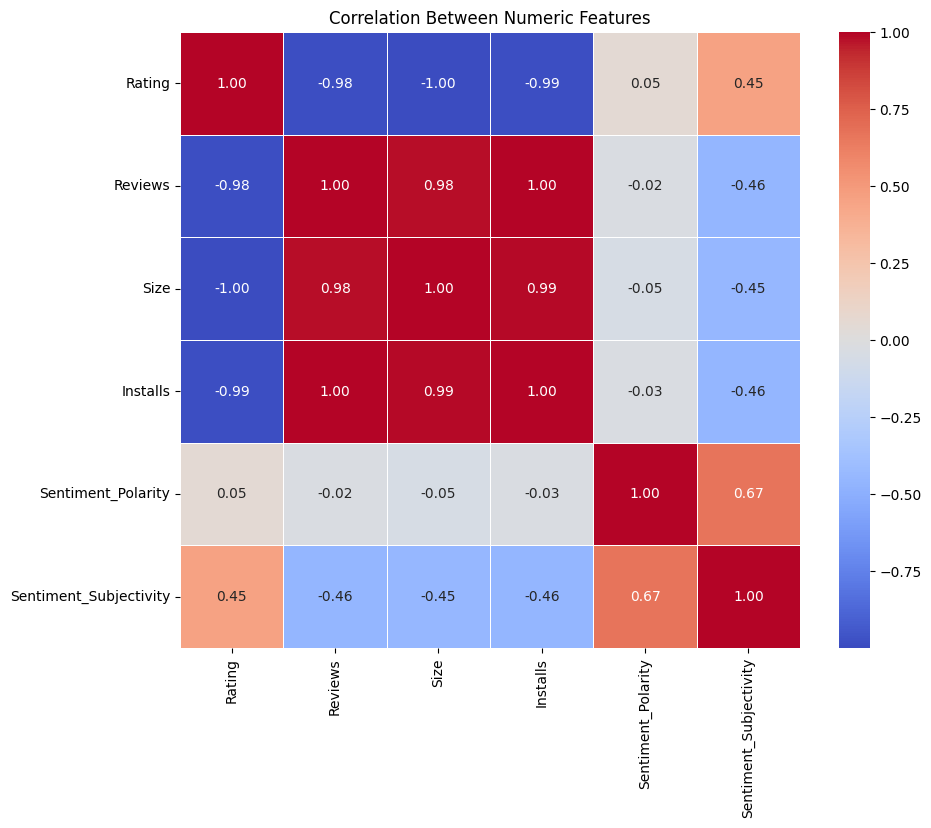

In [187]:
numeric_data = mergedAll[numeric_cols]

# Correlation matrix for numeric data
corr_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Numeric Features')
plt.show()

<ipython-input-190-d24f44f305af>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Rating', data=mergedAll, ci=None)  # ci=None to remove error bars


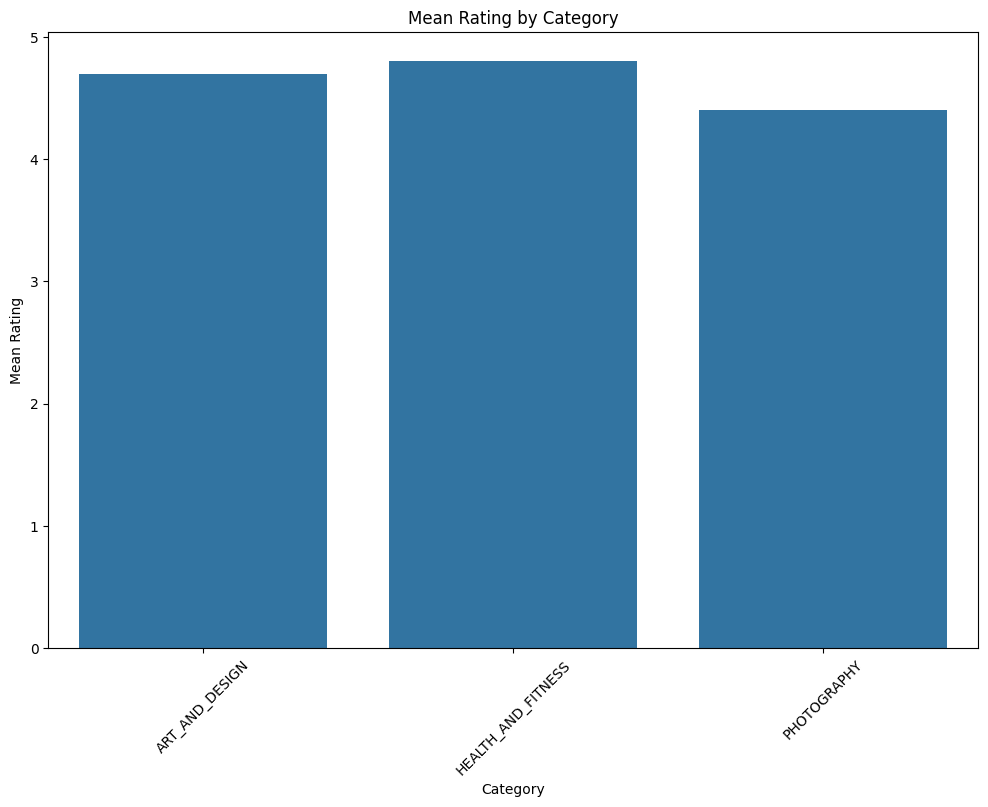

In [190]:
# Bar plot of mean Rating by Category
plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='Rating', data=mergedAll, ci=None)  # ci=None to remove error bars
plt.title('Mean Rating by Category')
plt.xticks(rotation=45)
plt.ylabel('Mean Rating')
plt.xlabel('Category')
plt.show()
